# Evolving convection of a Darcy fluid

In [1]:
import numpy as np
from lucifex.solver import OptionsPETSc
from lucifex.fdm import AB2, CN
from lucifex.sim import run, xdmf_to_npz
from lucifex.viz import plot_colormap, create_animation, plot_line, save_figure, display_animation, get_ipynb_file_name
from crocodil.dns import dns_darcy_evolving

STORE = 1
WRITE = None
DIR_BASE = f'./data_{get_ipynb_file_name()}'
DIR_PARAMS = ('Ra', 'Nx', 'Ny')

simulation = dns_darcy_evolving(
    store_delta=STORE, 
    write_delta=WRITE, 
    dir_base=DIR_BASE, 
    dir_params=DIR_PARAMS,
)(
    aspect=2.0,
    Nx=64,
    Ny=64,
    cell='quadrilateral', 
    scaling='advective',
    Ra=500.0, 
    theta_ampl=1e-4, 
    theta_freq=(14, 14), 
    theta_seed=(456, 987), 
    D_adv=CN,
    D_diff=CN,
    theta_stabilization=10.0,
    theta_petsc=None,
    flow_petsc=(OptionsPETSc('cg', 'hypre'), None),
    diagnostic=True,
)

n_stop = 50
dt_init = 1e-6
n_init = 10
run(simulation, n_stop=n_stop, dt_init=dt_init, n_init=n_init)

if WRITE:
    xdmf_to_npz(simulation, delete_xdmf=False)

theta, u, psi = simulation['theta', 'u', 'psi']

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_fa69245b7490bc9e33da86a8086a4461d25a1a18' extension
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/George/miniconda3/envs/lucifex/include -fPIC -O2 -isystem /Users/George/miniconda3/envs/lucifex/include -I/Users/George/miniconda3/envs/lucifex/lib/python3.10/site-packages/ffcx/codegeneration -I/Users/George/miniconda3/envs/lucifex/include/python3.10 -c libffcx_forms_fa69245b7490bc9e33da86a8086a4461d25a1a18.c -o ./libffcx_forms_fa69245b7490bc9e33da86a8086a4461d25a1a18.o -O2 -g0
INFO:root:clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/George/miniconda3/envs/lucifex/lib -L/Users/George/miniconda3/envs/lucifex/lib -Wl,-rpath,/Users/George/miniconda3/envs/lucifex/lib -L/Users/George/miniconda3/envs/lucifex/lib ./libffcx_forms_fa69245b7490bc9e33da86a8086a4461d25a1a18.o -o ./libffcx_forms_fa69245b7490bc9e33da86a8086a4461d25a1a18.cpython-310-darwin.

In [2]:
print(simulation.get_solver('theta').petsc)
print(simulation.get_solver('psi').petsc)

{'ksp_type': 'gmres', 'pc_type': 'ilu', 'ksp_rtol': 1e-06, 'ksp_atol': 1e-10, 'ksp_divtol': 10000.0, 'ksp_max_it': 10000}
{'ksp_type': 'cg', 'pc_type': 'hypre', 'ksp_rtol': 1e-06, 'ksp_atol': 1e-10, 'ksp_divtol': 10000.0, 'ksp_max_it': 10000}


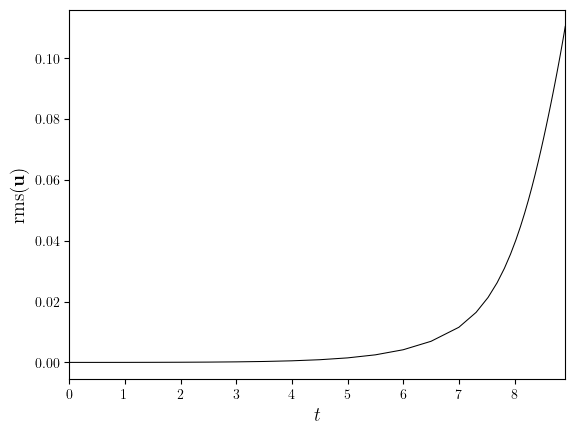

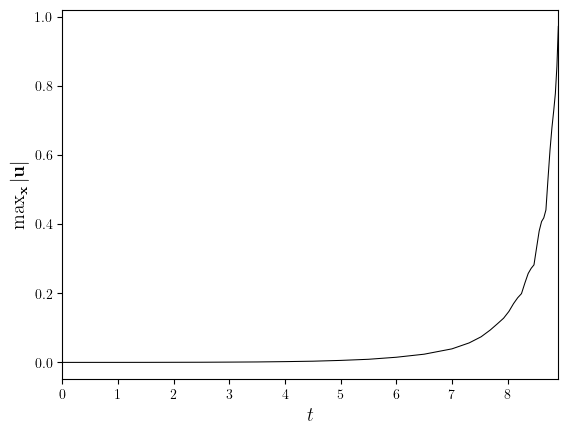

In [2]:
uRMS, uMinMax = simulation['uRMS', 'uMinMax']
uMax = uMinMax.sub(1)

fig, ax = plot_line(
    (uRMS.time_series, uRMS.value_series),
    x_label='$t$',
    y_label='$\mathrm{rms}(\mathbf{u})$',
)
save_figure('uRMS(t)', simulation.dir_path, prefix_ipynb=False)(fig)

fig, ax = plot_line(
    (uMax.time_series, uMax.value_series),
    x_label='$t$',
    y_label='$\max_{\mathbf{x}}|\mathbf{u}|$',
)
save_figure('uMax(t)', simulation.dir_path, prefix_ipynb=False)(fig)

In [2]:
time_slice = slice(0, None, 2)
titles = [f'$\\theta(t={t:.3f})$' for t in theta.time_series[time_slice]]

anim = create_animation(
    plot_colormap,
    colorbar=False,
)(theta.series[time_slice], title=titles)
anim_path = save_figure(f'{theta.name}(t)', simulation.dir_path, get_path=True)(anim)

display_animation(anim_path)

In [ ]:
q = simulation['q']
q, qPlus, qMinus = q.split()

fig, ax = plot_line(
    [(q.time_series, [np.sum(i) for i in q.value_series]), (q.time_series, q.value_series)],
    cyc='black',
    x_label='$t$',
    legend_labels=['$Q$', '$Q_{\\textbf{u}}$', '$Q_{\mathsf{G}}$'],
    legend_title='$y=1^-$',
)
save_figure('q(t)', simulation.dir_path, prefix_ipynb=False)(fig)

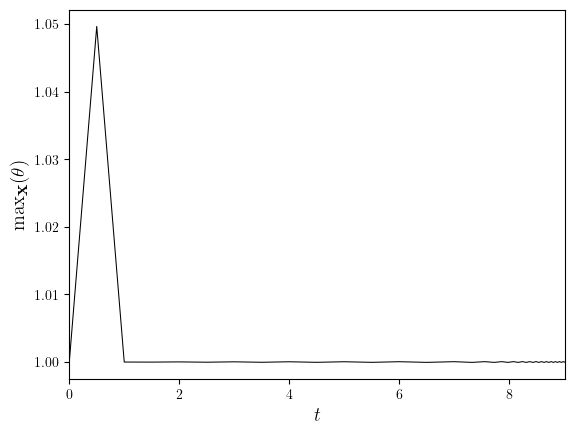

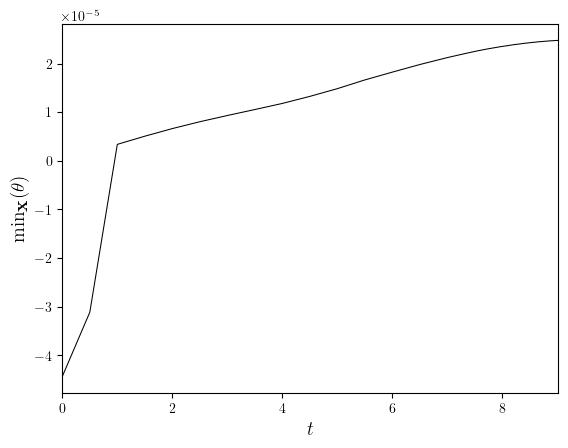

In [3]:
thetaMinMax = simulation['thetaMinMax']
thetaMin, thetaMax = thetaMinMax.split()

fig, ax = plot_line(
    (thetaMax.time_series, thetaMax.value_series),
    x_label='$t$',
    y_label='$\max_{\\textbf{x}}(\\theta)$',
)
save_figure('thetaMax(t)', simulation.dir_path)(fig)

fig, ax = plot_line(
    (thetaMin.time_series, thetaMin.value_series),
    x_label='$t$',
    y_label='$\min_{\\textbf{x}}(\\theta)$',
)
save_figure('thetaMin(t)', simulation.dir_path)(fig)